# Weather and happiness

## Introduction

Using data from the 2020 world happiness report (retrieved from Wikipedia) as well as weather data from the OXCOVID-19  database, I look to answer the question ‘how does weather, as measured by average temperature, impact a country’s happiness index?’ 
The effect of weather on happiness has received considerable study both at micro and macro levels. At a micro level research by Tsutsui (2013) on the happiness level of 75 students at Osaka university over a time period of 516 days found a quadratic relationship between happiness and temperature with happiness maximised at 13.98 C. This study is supported by similar findings that lower temperatures correlate with higher levels of wellbeing (and vice versa, assessed over summer) and that women are much more responsive than men to the weather (Connolly, 2013). Using data disaggregated at a local and individual level Brereton et al (2007) find that windspeed has a negative and significant correlation to personal wellbeing. 

Larger studies include Rehdanza and Maddison (2005) who analyse the effects of climate on happiness across 67 countries, controlling for relevant socio-economic factors such as GDP per capita, and finding that in warmer seasons people prefer colder average temperatures whilst in colder seasons people prefer warmer average temperatures. This alludes to the element of variation in temperature playing a notable role in determining happiness.

The rational supporting the use of the 2020 ‘World happiness report’ (Helliwell, Layard, Sachs, & Neve, 2020) is that at the time of writing this was the most recent and comprehensive data set on ’happiness’ at a global level. This data is accessed via the Wikipedia page titled ‘World Happiness Report’ (Wikipedia, 2020) due to the ease of use in accessing the data (via Wikipedia API rather than ‘copy/pasting’ data from the world happiness report pdf file) and as the page is classified with ‘Pending Changes Protection’ it ensures that the data contained within has protections to ensure it's accuracy (i.e. there are some checks and balances before the data is changed). The index is calculated through a globally administered survey which asks respondents to rate their lives on a scale of 1 to 10 (10 being the best) and then averages this across the country (Wikipedia, 2020) (limitations of 'measuring' happiness are discussed further below).

The timeframe analysed is from January 01 to October 31 for the weather data from the OXCOVID-19  database whilst the world happiness report 2020 gives an average of the happiness index for every country averaged over the years 2017 – 2019. The key assumption that justifies this choice of data despite the temporal differences is that the weather has been relatively constant between 2019 and 2020. In addition to this, the COVID-19  pandemic has heavily impacted people’s happiness at a global level, therefore it can be argued that last years happiness level indicator would be the best estimate for this year’s happiness index in lieu of the effect of COVID-19.

As this analysis is focused on happiness at a global level weather is considered at a country level. To account for the large variation in weather present in very large countries, the analysis is limited to countries with a land area less than 450,000 km^2. This allows for ~75% of the countries in the world to be considered.

In [2]:
try: 
    import seaborn as sns
    if sns.__version__ == "0.11.0": 
        pass
    else: 
        import sys
        !{sys.executable} -m pip install --upgrade seaborn==0.11.0
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install seaborn==0.11.0
    import seaborn as sns
    
print(sns.__version__ == "0.11.0")

import psycopg2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 200

import seaborn as sns

import numpy as np
import pandas as pd
import math 
import datetime

from bs4 import BeautifulSoup 

# Wikipedia API
import wikipedia
#wikipedia.set_lang("en") 


True


In [3]:
# Load in happiness data

happiness_index_wikiObj = wikipedia.page("World Happiness Report", preload=True) #preload=True
happiness_index_html = happiness_index_wikiObj.html()

soup = BeautifulSoup(happiness_index_html, 'html.parser')
Happiness_index_2020_soup = soup.find('table',{'class':"wikitable"})
df_Happiness_2020 = pd.read_html(str(Happiness_index_2020_soup))
df_Happiness_2020 = pd.DataFrame(df_Happiness_2020[0])

In [4]:
# Load in weather data

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='******')

cur = conn.cursor()
sql_command_1 = """SELECT date, country, countrycode, AVG(temperature_mean_avg) AS temperature_mean_avg
                        , AVG(sunshine_mean_avg) AS sunshine_mean_avg
                    FROM weather  
                    WHERE date > '2019-12-31' AND date<'2020-11-01'
                        AND source= 'MET'
                    GROUP BY date, country, countrycode
                     """
sql_command_2 = """ SELECT countrycode,value 
                        FROM world_bank 
                        WHERE indicator_name = 'Land area (sq. km)' 
                            AND value<450000 AND year > 1960 """

df_weather = pd.read_sql(sql_command_1, conn)
df_LandSizes = pd.read_sql(sql_command_2, conn)

conn.close()

In [5]:
# Limit to countries with a landsize less than 450,000 (~75% of countries in the world)
df_weather = df_weather.merge(df_LandSizes,
                              how='inner',
                              on='countrycode')
assert df_weather.isna().sum().sum() == 0, "Null values present"

# Convert units date, Temperature Kelvin to Celius
df_weather['date'] = pd.to_datetime(df_weather['date'],format='%Y-%m-%d')
df_weather['temperature_mean_avg_C'] = df_weather['temperature_mean_avg'].apply(lambda x: x-274.15)


df_weather_avg = df_weather[['date', 'countrycode', 'country', 'temperature_mean_avg_C']].groupby(['country']).mean()
df_weather_happy_country = df_Happiness_2020[['Score','Overall rank', 'Country or region']].merge(df_weather_avg
                                                                                            , how='inner'
                                                                                            , left_on='Country or region'
                                                                                            , right_on = 'country')

In [6]:
# Function to plot scatter plot of happiness vs temperature with line of best fit
def happiness_temperature_scatter(df):
    sns.set_theme(style="whitegrid")
    fig, ax1 = plt.subplots()
    fig.set_dpi(150)
    df.sort_values("temperature_mean_avg_C", inplace=True)
    y=df["Score"]
    x=df["temperature_mean_avg_C"]
    g = ax1.scatter(x, y, c=x, cmap='Spectral_r')
    ax1.scatter(x, y, c=x, cmap='Spectral_r')

    ax1.set_title('Figure 1: Average temperature and happiness score')
    ax1.set_ylabel('Country happiness score')

    fig.colorbar(g,orientation='horizontal',pad=0.02,ticks=ax1.get_xticks(),anchor=(0,0), panchor=(0.1,0)
                 ,spacing='uniform',extendfrac='auto',fraction=0.07, label = 'Average Temperature (Degrees Celcius)') 
    ax1.set_xlabel(None)
    ax1.set_xticklabels([None])
    
    model2 = np.poly1d(np.polyfit(x, y, 1))
    ax1.plot(x, model2(x))

In [7]:
df_weather['month'] = df_weather['date'].apply(lambda x: x.month_name())
df_weather_avg_2 = df_weather[['date', 'country', 'temperature_mean_avg_C','month']].groupby(['country','month']).mean()
df_weather_happy_country_month = df_Happiness_2020[['Score','Overall rank', 'Country or region']].merge(df_weather_avg_2
                                                                                            , how='inner'
                                                                                            , left_on='Country or region'
                                                                                            , right_on = 'country')

top10_Countries = df_weather_happy_country_month.sort_values(by='Overall rank', ascending= True)[:100]
bottom10_Countries = df_weather_happy_country_month.sort_values('Overall rank', ascending= True)[-100:]

In [8]:
# Function to plot boxplot of 10 countries with the variation in weather
def happiness_tempvar_Hboxplot(df,plot_title):
    sns.set_theme(style="ticks")
    fig, ax1 = plt.subplots()
    
    fig.set_dpi(150)
    #fig.set_size_inches(3,2)
    sns.boxplot(data=df, x="temperature_mean_avg_C", y="Country or region"
                , whis=[0, 100], width=.7, palette="vlag")
    sns.stripplot(data=df, x="temperature_mean_avg_C", y="Country or region"
                  , size=4, color=".3", linewidth=0)
    ax1.xaxis.grid(True)
    ax1.set(ylabel="Countries ordered by \n happiness score (Descending)")
    ax1.set_title(plot_title)
    ax1.set_xlabel("Average temperature (Degrees Celcius)")
    #print(dir(ax))
    sns.despine(trim=False, left=False)

In [9]:
df_weather_happy_country['temp_range'] = df_weather_happy_country['temperature_mean_avg_C'].apply(lambda x: "less than 15 degrees celcius" if x<15 
                                                                                                  else 
                                                                                                  "Greater than 20 degrees celcius" if x>20 
                                                                                                  else "15 - 20 degrees celcius" )

# Function to plot scatter graph of average temperature and happiness divided between three temperature ranges
def hapiness_temp_3plots(df):
    graph = sns.FacetGrid(df, col ='temp_range',legend_out=True,sharex=False) 
    graph.map(sns.regplot, "temperature_mean_avg_C", "Score").add_legend() 
    graph.fig.set_size_inches(15,5)
    graph.fig.set_constrained_layout_pads(w_pad = 0.001, h_pad = 5.0/70.0 ,
                                          hspace = 0.7, wspace = 0.7)
    graph.set_xlabels("Average temperature (Degrees Celcius)")
    graph.set_ylabels("Happiness index")
    graph.fig.set_dpi(300)
    plt.show() 
#hapiness_temp_3plots(df_weather_happy_country)

## Discussion

<ipython-input-6-5832af79b5c8>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([None])


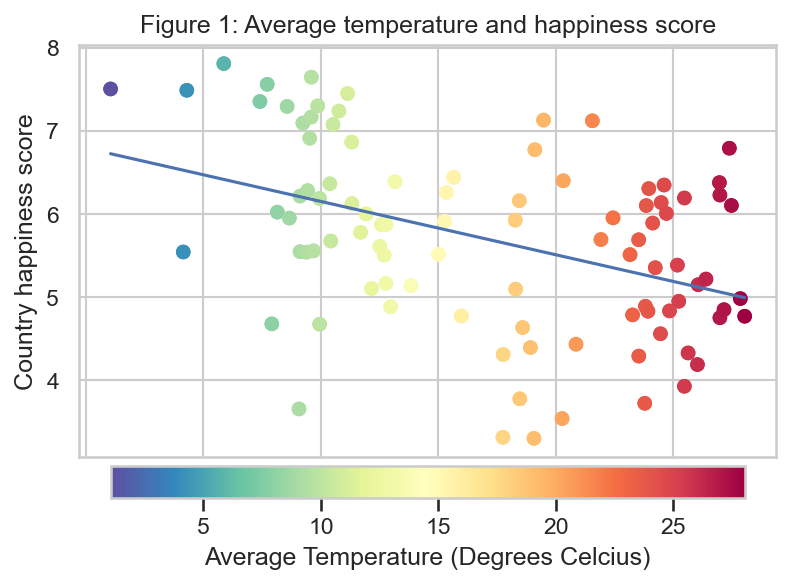

In [10]:
happiness_temperature_scatter(df_weather_happy_country)

The first section of analysis concerns the relationship between temperature and weather as shown by figure 1. Within this graph, ‘average temperature’ is calculated as an average of the average daily temperature, segmented by country, from January to October. The graph shows a relatively strong negative relationship between the average temperature in a country and the countries happiness score. This relationship is in line with research indicating that people tend to be happier in countries with relatively colder weather however it does not suggest a quadratic relationship between weather and happiness maximized at 13 C as found by Tsutsui (2013). A possible reason for this is that the research by Tsutsui was focused on happiness and weather at a local micro level whereas this research has a global macro focus.

A limitation of this analysis is that it does not consider the vast seasonal changes in temperature which are experienced by countries which experience the four seasons of spring, summer, autumn and winter. The following two charts take this into account showing the yearly variation in weather for the top 10 happiest and least happiest countries.

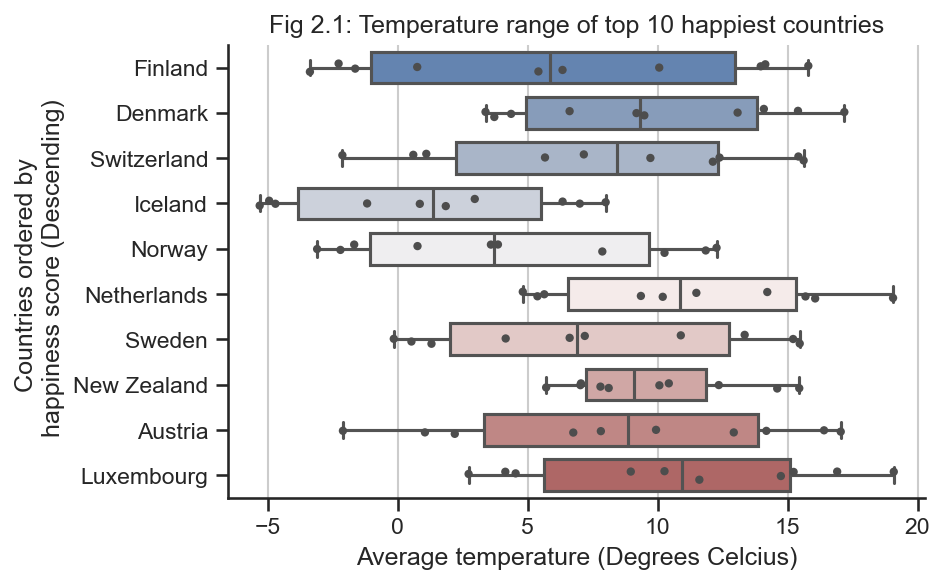

In [11]:
happiness_tempvar_Hboxplot(top10_Countries,"Fig 2.1: Temperature range of top 10 happiest countries")

Figure 2.1 illustrates the average temperature variation for the top 10 happiest countries. Specifically, an average of the average daily temperature is taken for each month from January to October and is plotted on a horizontal boxplot.

This figure shows that the ‘happiest’ countries tend to have a very large range in temperature across the year. For majority of the countries considered here, the differences in average yearly temperature may in fact not be statistically different as they fall within the middle 50% range of the boxplot. Furthermore, for majority of the countries the average temperature falls within the range of 5 and 10 degrees Celsius. 

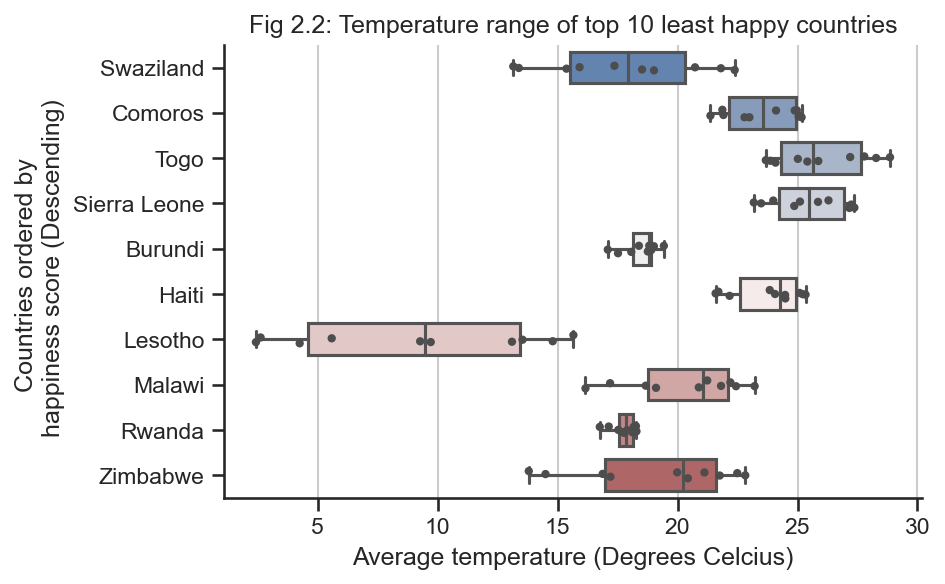

In [12]:
happiness_tempvar_Hboxplot(bottom10_Countries,"Fig 2.2: Temperature range of top 10 least happy countries")

Figure 2.2 inversely shows the yearly temperature variation of the top 10 least happy countries. This figure is significantly different to figure 2.1 in three different ways. Firstly, the temperature variation for each country is much smaller, with all but one of the boxplots having 50% of it's average weather values falling within a range of 5 degrees C or less. Secondly, the countries tend not to overlap each other in terms of their average temperature, with most of them having quite distinct average temperatures with little fluctuation. The final key difference is that each country tends to have a much higher temperature than the top 10 happiest countries. This is a glaring difference as majority of the least happy countries have a temperature above 20 degrees Celsius whilst none of the happiest countries contain 20 degrees Celsius in their temperature range, including outlier months. In fact, all but one of the top 10 happiest countries contains a temperature as high as 15 degrees Celsius in their boxplot's interquartile range suggesting a difference of 5 degrees Celsius between the happiest and least happiest countries.

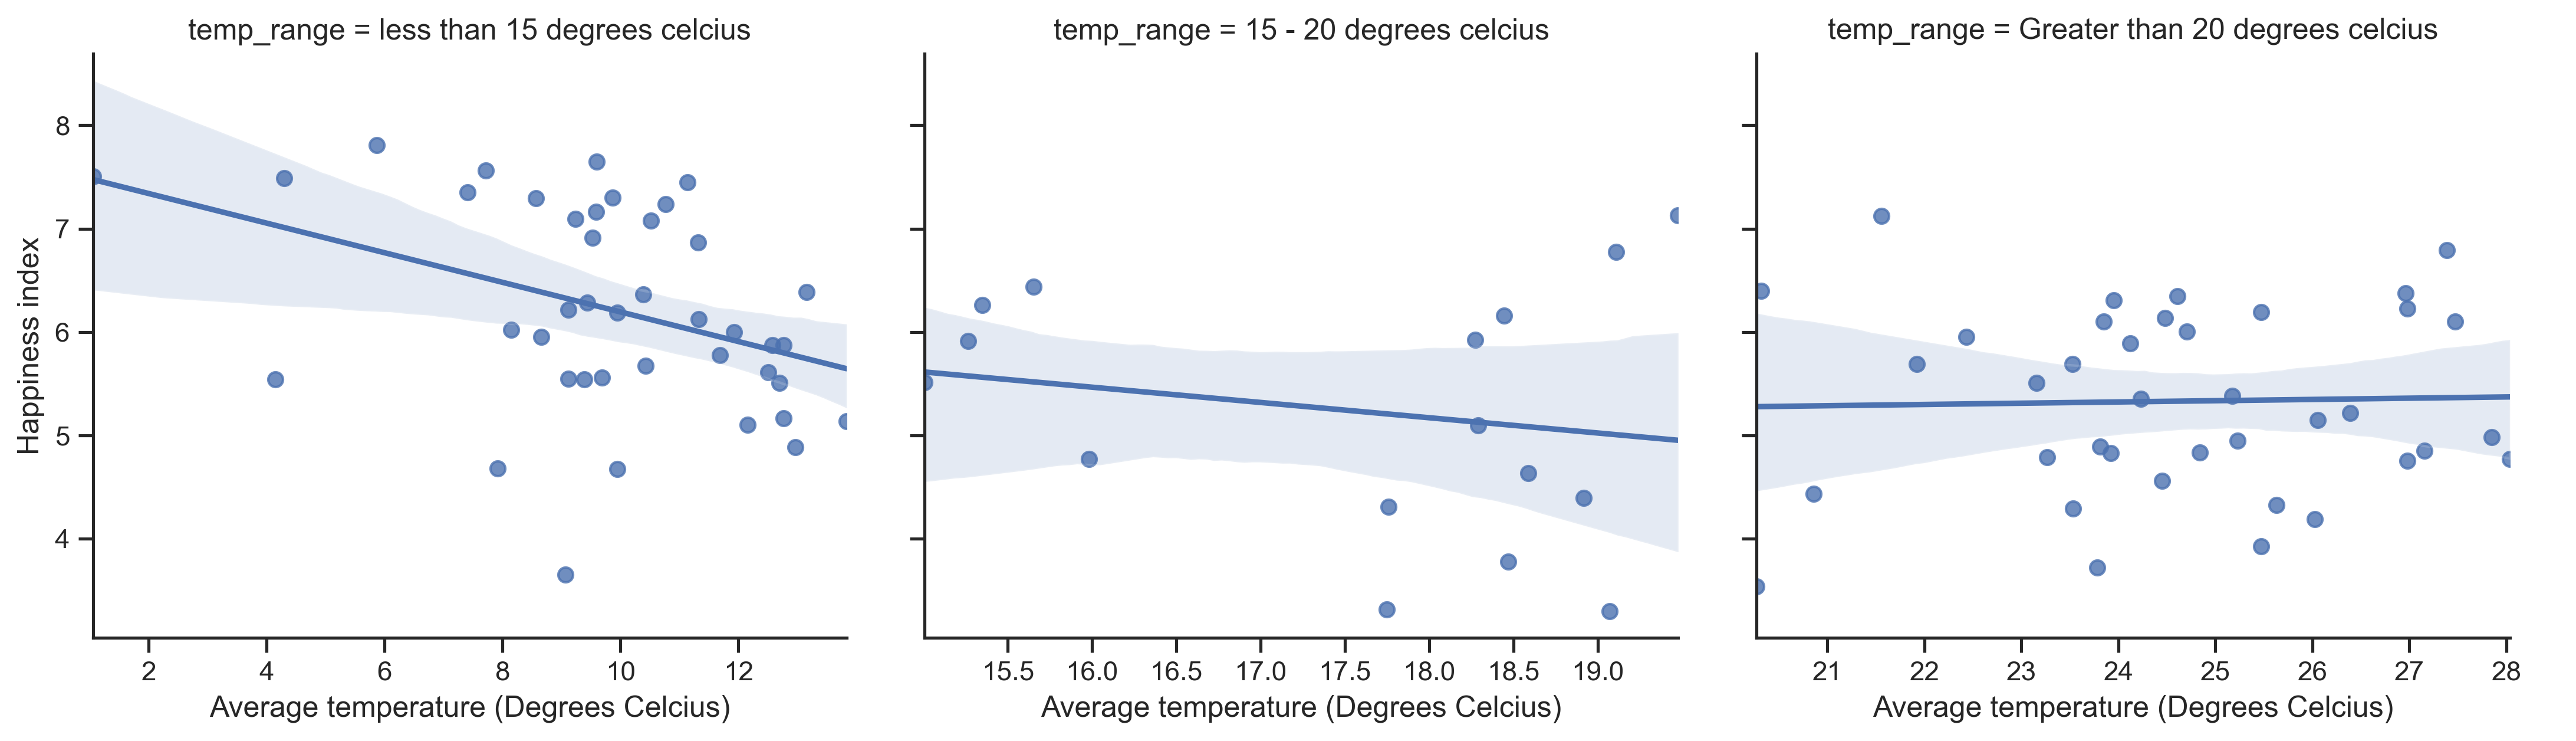

In [13]:
hapiness_temp_3plots(df_weather_happy_country)

Figure 3 delves deeper into the analysis of average yearly temperature and happiness index segmented by various temperature thresholds. The thresholds have been chosen based on the analysis of the previous pair of figures which showed clear divisions in average temperature between the happiest and least happiest countries as: less than 15 degrees Celsius, 15 – 20 degrees Celsius and greater than 20 degrees Celsius. From the graphs there is a negative relationship between average temperature and happiness for countries that have a  temperature less than 20 degrees Celsius, more pronounced among countries with a temperature between 15 and 20 degrees Celsius. However, among countries with an average temperature above 20 degrees Celsius there appears to be no relationship between happiness and temperature as shown by the largely horizontal line of best fit. 

In conclusion, the key findings from this analysis are that overall people in countries with a lower average temperature tend to be happier however this does not appear to hold true for countries with a temperature above 20 degrees Celsius on average. Additionally, people in countries with greater variability in temperature across the year tend to be happier.

# Limitations

A key limitation encountered in analysing the implications of various policies in response to Covid-19 includes data collection and definition discrepancies within countries. This is the case as measurements such as the number of confirmed cases would be directly related to amount of testing and testing strategies employed by each country, similarly the number of Covid-19 related deaths would depend on how each country records deaths as related to COVID-19 considering other comorbidities. Such variations in the collection of data limit the ability to compare outcomes regarding covid-19 across countries. An example of this is with Tanzania which stopped all public testing on 29th April. The scope of this analysis is therefore limited to being more descriptive in nature as it would be beyond the scope and quite challenging based on the aforementioned factors to quantify the impact of specific policies.

A challenge presented with the definition of the ‘happiness index’. Happiness is a highly subjective variable with determinants of happiness varying substantially between various regions and cultures. The perspective taken when constructing such an index runs the risk of being either too vague that it does not capture meaningful information or specific and biased towards one world-view or perspective that it does not provide a fair global comparison. Additionally, the construction of an index representing the happiness of an entire country may be misleading for countries that have huge socio-economic disparities or several highly distinct cultures and people. Possible extensions to this analysis could consider comparisons between weather and happiness across various happiness indexes.

Further limitations of the analysis of temperature and happiness are that temperature can vary greatly within both countries, although the countries considered were limited by size a trade-off had to be made based on how much in-country variation to allow buy considering larger countries versus how large of a global scope the analysis can cover, the decision was made to prioritize coverage at a global level and therefore the smallest ~75% of countries were considered.

An overall limitation of descriptive analysis is that although general correlations between variables can be identified, such analysis can not determine causation between two variables. This was clear in part two where although an overall positive correlation was identified between temperature and a countries happiness index, there would still exist several other factors that influence happiness that have not been considered and there is no clear explanation of how increased temperature relates to increases in happiness. Therefore, although descriptive analysis can provide a good starting point to explore the relationship between various variables it is not the final point.